In [1]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Main libraries used in Bayesian Optimisation Implementation using Gausian Process
import pymc as pm
from scipy.optimize import minimize, dual_annealing
from scipy.stats import norm


class bayes_optimizer():
    def __init__(self, objective_func, x_range, kernel='Matern52', mid_points=9, plot=True, mode="MCMC"):
        self.objective_func = objective_func  #Our blackbox function
        self.cov_func = kernel  #Kernel to be used
        # Parameters bounds to be used assuming the parameters are continuous
        # Can easily be extended to discrete space by using any mapping
        self.x_min = np.array(x_range[0]).reshape(-1,) 
        self.x_max = np.array(x_range[1]).reshape(-1,)
        self.dim = len(self.x_min)

        # Pickup mid_points initially between 0.1 - 0.9 of the parameter range
        # Sampling the objective function uniformly at mid_points
        self.x = self.x_min + np.linspace(0, 1, mid_points + 2) * (self.x_max - self.x_min)
        self.x = np.reshape(self.x, (len(self.x), 1))
        print(self.x)
        self.y = np.array([objective_func(i) for i in self.x]).reshape(-1,)
        self.if_plot = plot
        self.best_values = []
        self.mode = mode

    def Sampling(self, mode="OPT", acquisition="EI"):
        with pm.Model() as model:
            # setting D+3 hyperparameters for Gaussian process by sampling it from Gamma distributions  
            # These parameters govern the prior distriburions
            # How to get the best prior ??
            theta = pm.Gamma("theta", alpha=1, beta=1, shape=(self.dim,))
            theta0 = pm.Gamma("theta0", alpha=1, beta=1)
            # Using ARD Matern52 as covariance function to be used
            # Can experiment with other covariance functions 
            if self.cov_func == "Matern52":
                cov_func = theta0 ** 2 * pm.gp.cov.Matern52(input_dim=self.dim, ls=theta)
            # We will use constant mean for our Gaussian process
            m = pm.gp.mean.Constant(self.y.mean())
            gp = pm.gp.Marginal(mean_func=m, cov_func=cov_func)
            # For nu, using a Half-Cauchy distribution for noise
            nu = pm.HalfCauchy("nu", 1)
            gp.marginal_likelihood("f", X=self.x, y=self.y, noise=nu)

            if mode == "MCMC":
                N_trace = 1000 #Number of samples drawn
                thinning = 5 # Thinning factor
                trace = pm.sample(N_trace,chains=1)
                pm.plot_trace(trace)
                # Create multitrace object to pass after thinning
                theta_list = np.array(trace['posterior']['theta'].sel(draw=slice(0,N_trace-1,int(N_trace/thinning)))[0])
                theta0_list = np.array(trace['posterior']['theta0'].sel(draw=slice(0,N_trace-1,int(N_trace/thinning)))[0])
                nu_list = np.array(trace['posterior']['nu'].sel(draw=slice(0,N_trace-1,int(N_trace/thinning)))[0])
                trace_list = []
                for i in range(len(theta_list)):
                  trace_list.append({'theta': theta_list[i], 'theta0': theta0_list[i], 'nu': nu_list[i]})
                x_next = self.Get_next(params=trace_list,acquisition=acquisition,gp=gp)
                return x_next
            elif mode == "OPT":
                # Optimisation method
                MAP = pm.find_MAP()
                x_next = self.Get_next(params=MAP, acquisition=acquisition, gp=gp)
                return x_next

    def Get_next(self, params, acquisition, gp):
        # define acqusition function
        def acq(x_star):
            # print(f"Debug: {x_star}" , len(x_star))
            x_star = np.array(x_star).reshape(1, -1)
            if self.mode == 'MCMC':
                integrated_acq = []
                for t in params:
                    mean, var = gp.predict(x_star, point=t, diag=True, pred_noise=False)
                    mean = mean[0]
                    std = np.sqrt(var[0])
                    if acquisition == "EI":
                        #Expected Improvement
                        f_best = self.y.min()
                        gamma = (-f_best + mean) / std
                        integrated_acq.append((std * (norm.cdf(gamma) * gamma + norm.pdf(gamma))))
                    elif acquisition == "PI":
                        # Probability of improvement
                        f_best = self.y.min()
                        gamma = (-f_best + mean) / std
                        integrated_acq.append((norm.cdf(gamma)))
                    elif acquisition == "LCB":
                        # Tunable parameter Kappa in case of Lower Confidence bound
                        kappa = 1
                        integrated_acq.append((mean - (kappa) * std))
                return integrated_acq
            else: #OPT mode where there is no integration over various samples
                mean, var = gp.predict(x_star, point=params, diag=True, pred_noise=False)
                mean = mean[0]
                std = np.sqrt(var[0])
                if acquisition == "EI":
                    #Expected Improvement
                    f_best = self.y.min()
                    gamma = (-f_best + mean) / std
                    return std * (norm.cdf(gamma) * gamma + norm.pdf(gamma))
                elif acquisition == "PI":
                    # Probability of improvement
                    f_best = self.y.min()
                    gamma = (-f_best + mean) / std
                    return norm.cdf(gamma)
                elif acquisition == "LCB":
                    # Tunable parameter Kappa in case of Lower Confidence bound
                    kappa = 1
                    return mean - (kappa) * std

        # optimize for the best point from acquisition function
        # bounds = [(low, high) for low, high in zip(self.x_min, self.x_max)]
        # alpha_temp = np.random.rand(1)[0]
        # result = minimize(acq, x0=alpha_temp*self.x_min + (1-alpha_temp)*self.x_max, bounds=bounds)
        # result = dual_annealing(acq, bounds=bounds)
        
        # Expected Improvement Integration plotting
        debug_x = np.linspace(0, 1, 40)*(self.x_max - self.x_min) + self.x_min
        debug_y = []
        for i in debug_x:
            debug_y.append(acq(i))
        # ipdb.set_trace()
        plt.figure()
        plt.plot(debug_x, debug_y)
        plt.show()

        debug_y = np.array(debug_y)
        debug_y = np.mean(debug_y, axis=1)
        plt.figure()
        plt.plot(debug_x, debug_y)
        plt.show()
        #print('Got the plot; exiting the process')
        #exit(1)
        x_next = result.x
        print(f"x_next = {x_next}")
        
        return x_next

    def find_best(self, mode="MCMC", acquisition="EI", max_iter=10):
        for i in range(max_iter):
            print(f'----Iteration{i} started')
            self.best_values.append(np.min(self.y))
            x_new = self.Sampling(acquisition=acquisition, mode=mode)
            # if x_new in self.x:
            #     break
            y_new = self.objective_func(x_new)
            def plot_objective(self, func, point):
                x = np.linspace(self.x_min, self.x_max, 25)
                y = func(x)
                plt.figure()
                plt.plot(x, y, 'g--', label="Blackbox function")
                plt.scatter(self.x, self.y, marker='o', color="b", label="Existing pts")
                plt.plot([point], [func(point)], marker='o', markersize=10, color="red", label="Next pt")
                plt.legend(loc="best")
                plt.show()
            if self.if_plot:
                # Plot the objective/blackbox function with current values and next value
                # Can be used only in case of 1-D plots
                plot_objective(self, self.objective_func, x_new)
            self.x = np.vstack((self.x, x_new))
            self.y = np.hstack((self.y, y_new))
        return self.x[np.argmin(self.y)], self.best_values

    

[[ 0.        ]
 [ 1.25663706]
 [ 2.51327412]
 [ 3.76991118]
 [ 5.02654825]
 [ 6.28318531]
 [ 7.53982237]
 [ 8.79645943]
 [10.05309649]
 [11.30973355]
 [12.56637061]]
----Iteration0 started


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


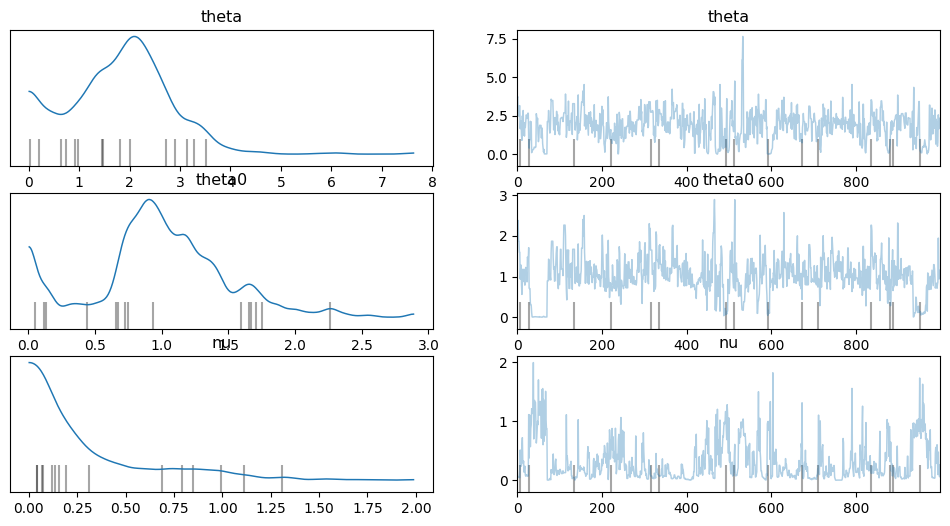

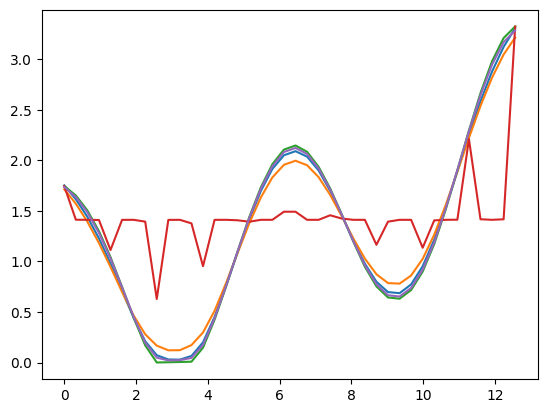

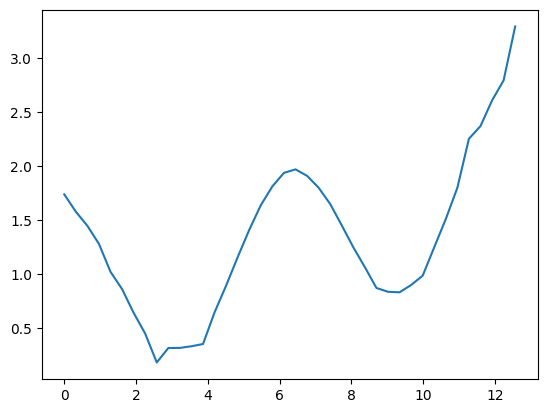

Got the plot; exiting the process


NameError: ignored

In [16]:
# Minimizing Griewank function of 1 dimension
g = lambda x:(x**2)/100 + (np.cos(x))
g_range = [0, 4*np.pi]
mid_points = 9
max_iter = 20
baye_1d_GP_OPT = bayes_optimizer(objective_func=g,x_range=g_range,mid_points=mid_points, mode="MCMC")
best_result, best_val_mcmc_ei = baye_1d_GP_OPT.find_best(mode = "MCMC",acquisition = "EI",max_iter = max_iter)
